# Compton Scattering Analysis
### By Xavier Moskala exm413@case.edu

In [1]:
# Importing modules needed for data analysis.
from scipy.odr import ODR, Model, Data, RealData
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import stats
from scipy.stats import norm
from scipy.optimize import curve_fit,fmin
from scipy import signal as ss
from scipy import constants as cs
from pylab import *
import glob

In [2]:
# Make a list of lines on .spe files to be ignored
skip=[0,1,2,3,4,5,6,7,8,9,10,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074]

# Useful helper functions
## Reads multiple files
def read_multi_csv(start_sample,end_sample,path):     
    samples = list(range(start_sample,end_sample+1))     
    dfs = []
    for N in samples:
        if N <= 9:
            file = 'https://gitlab.com/xmoskala/srlab/-/raw/main/Compton'+path+"00"+str(N)+'.SPE'
        elif N <= 99:
            file = 'https://gitlab.com/xmoskala/srlab/-/raw/main/Compton'+path+"0"+str(N)+'.SPE'  
        else: 
            file = 'https://gitlab.com/xmoskala/srlab/-/raw/main/Compton'+path+str(N)+'.SPE'  
        file = file.replace(" ", "%20")
        #print (file)         
        df = pd.read_csv(file, skiprows=skip, header=0, names=["Data"])         
        dfs.append(df) 
    return dfs
## Averages the multiple files read
def aver(files):
    sample = files[0]
    for i in range(len(files)):
        sample = sample.add(files[i], axis=0)
    sample = sample.div(len(files)).add(0.5).astype(int)
    return sample
## Function to fix spaces in urls
def url(path):
    path = 'https://gitlab.com/xmoskala/srlab/-/raw/main/Compton'+path+'000.SPE'
    path = path.replace(" ", "%20")
    return path
def url2(path):
    path = 'https://gitlab.com/xmoskala/srlab/-/raw/main/Compton'+path+'.SPE'
    path = path.replace(" ", "%20")
    return path
def url3(path):
    path = 'https://gitlab.com/xmoskala/srlab/-/raw/main/Compton'+path+'.Spe'
    path = path.replace(" ", "%20")
    return path
def unit(data):
    return data/max(data)

def pk_find(deg, width, plot):
    x = np.arange(0,2048,1)[0:2047]
    peak = int(ss.find_peaks_cwt(deg[width[0]:width[1]],x[width[0]:width[1]]))+width[0]
    if plot>0:
        fig, ax = plt.subplots()

        ax.plot(x[width[0]:width[1]],deg[width[0]:width[1]])
        ax.axvline(peak)
    else: return peak
    
def alt_pk_find(deg, width, dist, choice, plot):
    x = np.arange(0,2048,1)[0:2047]
    peak = ss.find_peaks(deg[width[0]:width[1]], distance=dist)[0][choice]+width[0]
    if plot>0:
        fig, ax = plt.subplots()

        ax.plot(x[width[0]:width[1]],deg[width[0]:width[1]])
        ax.axvline(peak)
    else: return peak

In [3]:
# Read spectrum files (.spe) as .csv with pandas

## Cs137 Readings

deg0 = pd.read_csv(url("/2-2-23/deg/0deg"), skiprows=skip, header=0, names=["Data"]).to_numpy().T[0][1:].astype(int) 
deg10 = pd.read_csv(url("/2-2-23/deg/10deg"), skiprows=skip, header=0, names=["Data"]).to_numpy().T[0][1:].astype(int)
deg20 = pd.read_csv(url("/2-2-23/deg/20deg"), skiprows=skip, header=0, names=["Data"]).to_numpy().T[0][1:].astype(int) 
deg30 = pd.read_csv(url("/2-2-23/deg/30deg"), skiprows=skip, header=0, names=["Data"]).to_numpy().T[0][1:].astype(int) 
deg40 = pd.read_csv(url("/2-2-23/deg/40deg"), skiprows=skip, header=0, names=["Data"]).to_numpy().T[0][1:].astype(int) 
deg50 = pd.read_csv(url("/2-2-23/deg/50deg"), skiprows=skip, header=0, names=["Data"]).to_numpy().T[0][1:].astype(int) 
deg60 = pd.read_csv(url("/2-2-23/deg/60deg"), skiprows=skip, header=0, names=["Data"]).to_numpy().T[0][1:].astype(int)
deg70 = pd.read_csv(url("/2-2-23/deg/70deg"), skiprows=skip, header=0, names=["Data"]).to_numpy().T[0][1:].astype(int) 
deg80 = pd.read_csv(url("/2-2-23/deg/80deg"), skiprows=skip, header=0, names=["Data"]).to_numpy().T[0][1:].astype(int) 
deg90 = pd.read_csv(url("/2-2-23/deg/90deg"), skiprows=skip, header=0, names=["Data"]).to_numpy().T[0][1:].astype(int) 


In [4]:
num = np.array([
        pk_find(deg0, [410,700], 0),
        pk_find(deg10, [400,600], 0),
        pk_find(deg20, [370,600], 0),
        pk_find(deg30, [330,700], 0),
        pk_find(deg40, [310,600], 0),
        pk_find(deg50, [260,600], 0),
        pk_find(deg60, [220,500], 0),
        pk_find(deg70, [200,500], 0),
        pk_find(deg80, [180,400], 0),
        pk_find(deg90, [160,400], 0)
       ])
angles = np.array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

Na= 392
#calibration
cal = 511/Na

#Errors from peak fitting function found at the bottom of document "Experiment 2 Data Analysis"
err = np.array([9,15,15,10,10,11,19,24,27,21])

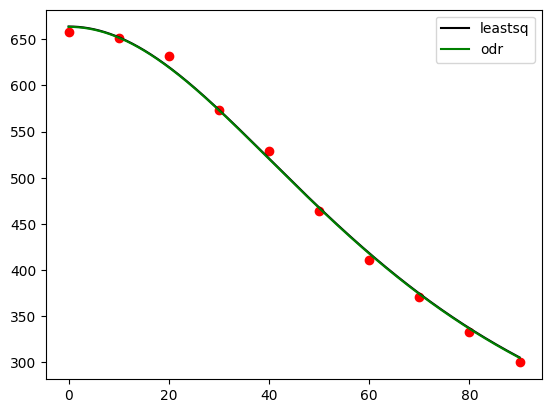

In [9]:
# If want x-error
a = 0.2 #inch
d = 8.5 #inch
angle = np.arcsin(a/np.sqrt(a**2+d**2))*180/np.pi

#Theory
## Electron mass: 511, Cs peak 661.2

def energy(beta, theta):
    E,m = beta
    theta = theta*np.pi/180
    return E/(1+(E/m)*(1-np.cos(theta)))

data = RealData(angles, cal*num, sx= angle, sy=err)
model = Model(energy)

odr = ODR(data,model, beta0=[0., 1.])
odr.set_job(fit_type=2)
output = odr.run()

x = np.arange(0,90,0.001)
y = energy(output.beta,x)

plot(angles,cal*num,'ro')
plot(x,y,'k-',label='leastsq')
odr.set_job(fit_type=0)
output = odr.run()
y = energy(output.beta, x)
plot(x,y,'g-',label='odr')
legend(loc=0)

E= output.beta[0]
me= output.beta[1]
merr= output.sd_beta[1]

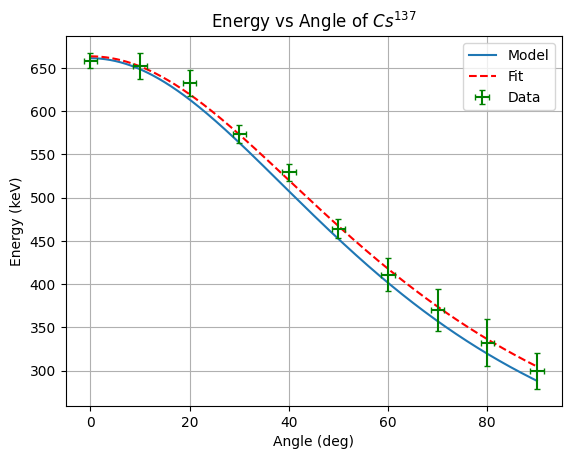

In [10]:
Na= 392
#quick cal
cal = 511/Na

x = np.arange(0,90,0.001)

fig, ax = plt.subplots()

ax.plot(x,energy([661.2,511], x ), label="Model")
ax.plot(x, energy([E,m], x), ls='--', color='r', label="Fit")
ax.errorbar(angles, cal*num,
            xerr=angle,
            yerr=err,
            fmt=' ',
            capsize=2,
            color='g',
            label="Data")
#ax.plot(angles, cal*num, marker='.', ls='', color='g')
#ax.axvline(0, ls='--', color='black')
#ax.axvline(90, ls='--', color='black')

plt.xlim(-5,95)
#plt.ylim(0,1.1)

ax.set(xlabel='Angle (deg)', ylabel='Energy (keV)',
       title='Energy vs Angle of $Cs^{137}$')
ax.grid()
ax.legend(loc='upper right')

plt.savefig('10minDATA.png', dpi=1000)
plt.show()

In [11]:
def kev2kg(value):
    return (10**3*cs.e*(value))/cs.c**2

h = cs.physical_constants['Planck constant'][0] #J*s
c = cs.physical_constants['speed of light in vacuum'][0] #m*Hz

In [12]:
dlam = h/(kev2kg(me)*c)
dlamerr = (merr/me)*dlam

print("Compton wavelength = " + str(dlam) +" ± "+ str(dlamerr))

Compton wavelength = 2.198963563626351e-12 ± 5.75366619059286e-14


In [ ]:
Na= 392
#quick cal
cal = 511/Na

x = np.arange(0,2048,1)[0:2047]

fig, ax = plt.subplots()

ax.plot(cal*x[450:600], deg0[450:600], label="0°", ls='', marker='.',   color='red')
ax.plot(cal*x[450:600], deg10[450:600], label="10°", ls='', marker='.', color='orange')
ax.plot(cal*x[450:600], deg20[450:600], label="20°", ls='', marker='.', color='gold')
ax.plot(cal*x[400:550], deg30[400:550], label="30°", ls='', marker='.', color='yellowgreen')
ax.plot(cal*x[350:500], deg40[350:500], label="40°", ls='', marker='.', color='green')
ax.plot(cal*x[300:450], deg50[300:450], label="50°", ls='', marker='.', color='cornflowerblue')
ax.plot(cal*x[250:420], deg60[250:420], label="60°", ls='', marker='.', color='royalblue')
ax.plot(cal*x[200:390], deg70[200:390], label="70°", ls='', marker='.', color='mediumorchid')
ax.plot(cal*x[200:370], deg80[200:370], label="80°", ls='', marker='.', color='blueviolet')
ax.plot(cal*x[180:350], deg90[180:350], label="90°", ls='', marker='.', color='indigo')


#ax.axvline(cal*num[0], color='red')
#ax.axvline(cal*num[1], color='orange')
#ax.axvline(cal*num[2], color='gold')
#ax.axvline(cal*num[3], color='yellowgreen')
#ax.axvline(cal*num[4], color='green')
#ax.axvline(cal*num[5], color='cornflowerblue')
#ax.axvline(cal*num[6], color='royalblue')
#ax.axvline(cal*num[7], color='mediumorchid')
#ax.axvline(cal*num[8], color='blueviolet')
#ax.axvline(cal*num[9], color='indigo')

plt.xlim(cal*180,cal*590)
#plt.ylim(0,1.1)

ax.set(xlabel='Energy (keV)', ylabel='Counts',
       title='Counts vs Energy of $Cs^{137}$')
ax.grid()
ax.legend()

plt.savefig('cvE.png', dpi=1000)
plt.show()